Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

Let's import the libreries.

In [1]:
import pandas as pd
import numpy as np
import math 
!pip install sidetable
import sidetable as stb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

Let's import the data.

In [2]:
df=pd.read_csv('/datasets/car_data.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Let's cahnge the uppercase latters to lowercase to evoid misstakes in the future codes.

In [3]:
df.columns=df.columns.str.lower()

In [4]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [5]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Now all columns are lowercase names.

There are some features that has no indluence on vehicle price such as datecrawled, postalcode and last seen, therefore they will be removed from the dataframe.

In [6]:
df=df.drop(['datecrawled','postalcode','lastseen'],axis=1)

In [7]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0


Let's check the data info.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicletype        316879 non-null  object
 2   registrationyear   354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   mileage            354369 non-null  int64 
 7   registrationmonth  354369 non-null  int64 
 8   fueltype           321474 non-null  object
 9   brand              354369 non-null  object
 10  notrepaired        283215 non-null  object
 11  datecreated        354369 non-null  object
 12  numberofpictures   354369 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 35.1+ MB


From the info above datecreated feature needs to be converted to datetime type to calculate age of the vehicle in the next steps.

In [9]:
df['datecreated'] = pd.to_datetime(df.datecreated)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              354369 non-null  int64         
 1   vehicletype        316879 non-null  object        
 2   registrationyear   354369 non-null  int64         
 3   gearbox            334536 non-null  object        
 4   power              354369 non-null  int64         
 5   model              334664 non-null  object        
 6   mileage            354369 non-null  int64         
 7   registrationmonth  354369 non-null  int64         
 8   fueltype           321474 non-null  object        
 9   brand              354369 non-null  object        
 10  notrepaired        283215 non-null  object        
 11  datecreated        354369 non-null  datetime64[ns]
 12  numberofpictures   354369 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

Now the datecreated feature is in desired type.

Now let's separate the datecreated feature to year, month etc...

In [11]:
df['created_year'] = df.datecreated.dt.year
df['created_month'] = df.datecreated.dt.month
df['created_day'] = df.datecreated.dt.day
df['created_dayofweek'] = df.datecreated.dt.dayofweek

In [12]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,created_year,created_month,created_day,created_dayofweek
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,2016,3,24,3
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,2016,3,24,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,2016,3,14,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,2016,3,17,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,2016,3,31,3


From this point we don't need the datecreated feature since it was separated.

In [13]:
df.drop('datecreated',axis=1,inplace=True)

In [14]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,numberofpictures,created_year,created_month,created_day,created_dayofweek
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,2016,3,24,3
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,2016,3,24,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,2016,3,14,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,2016,3,17,3
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,2016,3,31,3


Let's see the distribution of numeric data.

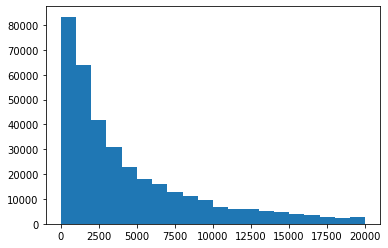

In [15]:
plt.hist(df['price'], bins = 20)
plt.show()

In [16]:
df.price.max()

20000

In [17]:
df.price.min()

0

The values are in normal range (no outliers)

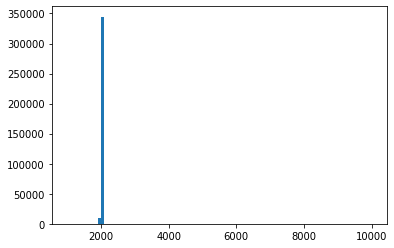

In [18]:
plt.hist(df['registrationyear'], bins = 100)
plt.show()

In [19]:
df.registrationyear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [20]:
df.groupby('registrationyear').size()

registrationyear
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Length: 151, dtype: int64

In [21]:
df[df.registrationyear==1111]

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,numberofpictures,created_year,created_month,created_day,created_dayofweek
622,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,0,2016,3,16,2
215678,490,NaN,1111,NaN,0,NaN,5000,0,NaN,trabant,NaN,0,2016,3,17,3
294028,0,NaN,1111,NaN,0,601,5000,0,NaN,trabant,NaN,0,2016,3,28,0


It seems that some values of registration year make no sense so we have to remove thouse values (rows) from the data set.

In [22]:
df=df.drop(df[df['registrationyear']< 1925].index)


In [23]:
df.registrationyear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970,
       1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967, 1959, 9999,
       1956, 3200, 1941, 8888, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1953, 8000, 5300, 9000, 2900, 6000,
       5900, 5911, 1933, 1950, 4000, 1948, 1952, 8500, 1932, 3700, 3800,
       4800, 1942, 7000, 1935, 1936, 6500, 2290, 2500, 1930, 9450, 1944,
       1943, 1934, 1938, 2800, 1928, 5555, 5600, 2222, 9996, 8455, 1931,
       4500, 7800, 9229, 1947, 1927, 7100, 8200, 1946, 7500, 3500])

In [24]:
df=df.drop(df[df['registrationyear']>= 2022].index)

In [25]:
df.registrationyear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970,
       1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941,
       1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933, 1950,
       1948, 1952, 1932, 1942, 1935, 1936, 1930, 1944, 1943, 1934, 1938,
       1928, 1931, 1947, 1927, 1946])

In [26]:
df.registrationyear.min()

1925

In [27]:
df.registrationyear.max()

2019

No more strange value for years.

In [28]:
df.groupby('registrationyear').size()

registrationyear
1925        1
1927        1
1928        2
1929        7
1930        3
        ...  
2015     1302
2016     9599
2017    10441
2018     3959
2019       25
Length: 93, dtype: int64

In [29]:
df.shape

(354092, 16)

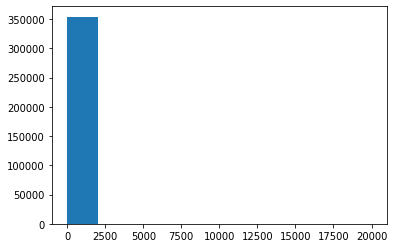

In [30]:
plt.hist(df['power'], bins = 10)
plt.show()

In [31]:
df.power.unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

There are power values that make no sense like 15000, even in tuned vehicles there are let's assume 5000 HP but not 15000.

The same goes for small values like 8 or so. Let's assume that the minimum HP is 70 HP, so the range that I will use is between 70 and 5000 HP.

In [32]:
df=df.drop(df[df['power']< 70].index)

In [33]:
df=df.drop(df[df['power']> 5000].index)

In [34]:
df.power.unique()

array([ 190,  163,   75,  102,  109,  125,  101,  105,  140,  115,  131,
        136,  160,  231,   90,  118,  193,   99,  113,  218,  122,  129,
         70,  306,   95,  177,   80,  170,  143,  286,  232,  150,  156,
         82,  155,  185,   87,  180,   86,   84,  224,  235,  200,  178,
        265,   77,  110,  144,  120,  116,  184,  126,  204,   88,  194,
        305,  197,  179,  250,  313,  165,   98,  130,  114,  211,  201,
        213,  107,   83,  174,  100,  220,   85,   73,  192,  299,   74,
        147,  310,   71,   97,  239,  203,  300,  103,  258,  320,   81,
        148,  145,  230,  280,  260,  104,  188,  333,  186,  117,  141,
        132,  234,  158,   92,  135,  209,  146,  106,  166,  276,  344,
         72,  249,  237,  245,  111,  326,  279,  138,  175,   96,  226,
        301,  334,  128,  133,  124,  219,  241,  167,   94,  182,  196,
        238, 1398,  228,  112,  272,  139, 1799,  240,   79,  256,  360,
        243,  375,  252,  396,  340,  108,  121,  3

In [35]:
df.power.min()

70

In [36]:
df.power.max()

5000

Now the range of HP is noraml.

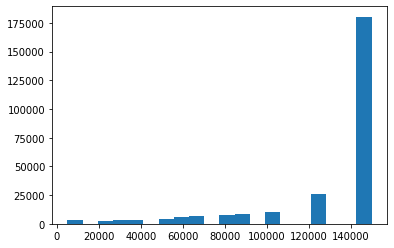

In [37]:
plt.hist(df['mileage'], bins = 20)
plt.show()

In [38]:
df.mileage.unique()

array([125000, 150000,  30000,  70000, 100000,  60000,  20000,  50000,
        40000,   5000,  10000,  90000,  80000])

The mileage is normal in my opinion.

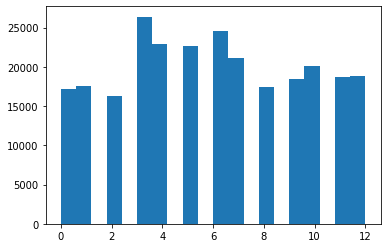

In [39]:
plt.hist(df['registrationmonth'], bins = 20)
plt.show()

In [40]:
df.registrationmonth.unique()

array([ 5,  8,  6, 10,  0, 12, 11,  2,  3,  1,  4,  7,  9])

Registration month 0 makes no sense so it will be removed from dataframe.

In [41]:
df=df.drop(df[df['registrationmonth']== 0].index)

In [42]:
df.registrationmonth.unique()

array([ 5,  8,  6, 10, 12, 11,  2,  3,  1,  4,  7,  9])

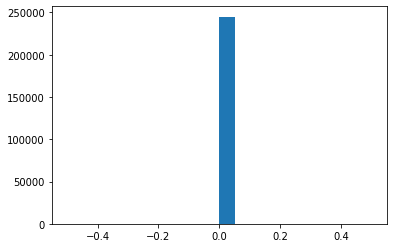

In [43]:
plt.hist(df['numberofpictures'], bins = 20)
plt.show()

In [44]:
df.numberofpictures.unique()

array([0])

No pictures in this df so it has no influence on the price therefore it will be removed from the dataframe.

In [45]:
df.drop('numberofpictures',axis=1,inplace=True)

In [46]:
df.head(3)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,created_year,created_month,created_day,created_dayofweek
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,3,24,3
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,3,14,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,3,17,3


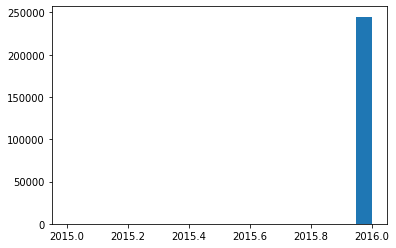

In [47]:
plt.hist(df['created_year'], bins = 20)
plt.show()

In [48]:
df.created_year.unique()

array([2016, 2015])

In [49]:
df.created_year.value_counts()

2016    244967
2015        19
Name: created_year, dtype: int64

In 2016 there were large registration of vehicles than it was in 2015. (maybe they became popular)

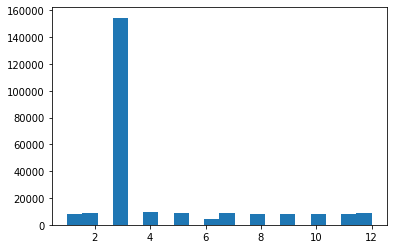

In [50]:
plt.hist(df['created_month'], bins = 20)
plt.show()

In [51]:
df.created_month.unique()

array([ 3,  4,  1,  7, 10,  8,  9, 11, 12,  2,  5,  6])

In [52]:
df.created_month.value_counts()

3     154522
4       9743
12      9036
7       8927
2       8892
5       8547
1       8405
9       8308
8       8110
10      7932
11      7916
6       4648
Name: created_month, dtype: int64

In March there were the most registrations.

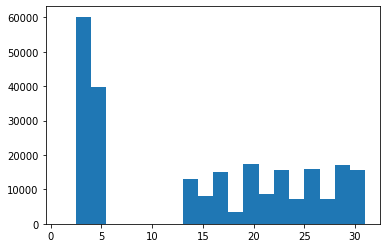

In [53]:
plt.hist(df['created_day'], bins = 20)
plt.show()

In [54]:
df.created_day.unique()

array([24, 14, 17,  4, 26, 15, 21, 20, 23, 27, 13, 18,  3, 25, 30, 29, 31,
       28,  2, 22, 16, 19, 11,  1, 12,  8,  9])

No problem with the range wicj is between 1 and 31.

In [55]:
df.created_day.value_counts()

3     60228
4     39822
20     9015
28     8853
21     8753
14     8662
29     8353
19     8342
30     8091
25     8059
15     7996
26     7974
22     7820
23     7795
31     7691
17     7617
16     7444
27     7351
24     7324
13     4240
18     3481
2        53
1        12
12        4
11        3
8         2
9         1
Name: created_day, dtype: int64

Most popular days are 3rd and 4th of the month.

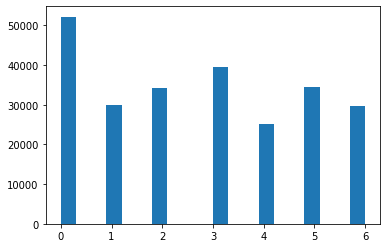

In [56]:
plt.hist(df['created_dayofweek'], bins = 20)
plt.show()

In [57]:
df.created_dayofweek.unique()

array([3, 0, 5, 1, 6, 2, 4])

In [58]:
df.created_dayofweek.value_counts()

0    52172
3    39461
5    34436
2    34269
1    29910
6    29665
4    25073
Name: created_dayofweek, dtype: int64

Most popular day of the week is monday begining of the week.

Let's create new feature wich is age of the vehicle.

In [59]:
df['car_age']=df.created_year - df.registrationyear

In [60]:
df.head(3)

,price,vehicletype,registrationyear,gearbox,power,model,mileage,registrationmonth,fueltype,brand,notrepaired,created_year,created_month,created_day,created_dayofweek,car_age
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,3,24,3,5
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,3,14,0,12
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,3,17,3,15


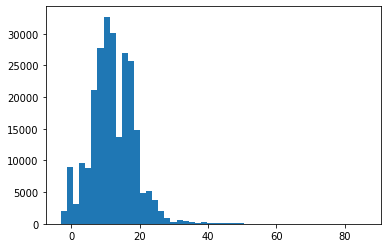

In [61]:
plt.hist(df['car_age'], bins = 50)
plt.show()

In [62]:
df.car_age.unique()

array([ 5, 12, 15, 21,  2, 11,  9,  7, 14, -2, 26, -1,  8,  0, 32, 10, 17,
       18,  4, 22, 16, 24, 19,  3, 13, 25, 20,  6,  1, 23, 27, 33, 35, 47,
       45, 29, 31, 28, 36, 30, 51, 42, 34, 38, 37, 44, 39, 40, 48, 50, 55,
       41, 57, 46, 43, 49, 67, -3, 58, 54, 52, 71, 60, 66, 53, 65, 74, 81,
       61, 56, 64, 62, 86, 59, 68, 79, 73, 63, 69])

From the age_car feature we see that there are some negative values and the reason is when before I filtered the years of registration the range was 1925 and 2022 however maximum value of year for profile creation is 2016 wich means that dataframe needs to filtered again.

In [63]:
df=df.drop(df[df['registrationyear']> 2016].index)

In [64]:
#Let's see the cars age again.
df.car_age.unique()

array([ 5, 12, 15, 21,  2, 11,  9,  7, 14, 26,  8,  0, 32, 10, 17, 18,  4,
       22, 16, 24, 19,  3, 13, 25, 20,  6,  1, 23, 27, 33, 35, 47, 45, 29,
       31, 28, 36, 30, 51, 42, 34, 38, 37, 44, 39, 40, 48, 50, 55, 41, 57,
       46, 43, 49, 67, 58, 54, 52, 71, 60, 66, 53, 65, 74, 81, 61, 56, 64,
       62, 86, 59, 68, 79, 73, 63, 69])

Now the values for cars age are normal. Also I will not remove or filter cars age like 86 years of age and the reason maybe someone want to sell old vehicle for collectors of vintage cars or for the museum.

Now we have the data for the cars age therefore we can remove the data refered information.

In [65]:
df.drop(['registrationyear','registrationmonth','created_year','created_month','created_day','created_dayofweek'],
       axis=1,inplace=True)

In [66]:
df.head(3)

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired,car_age
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15


Let's check for the dublicated data.

In [67]:
dubl=df.duplicated().sum()
print('The number of dublicated data is:',dubl)

The number of dublicated data is: 30221


Let's calculate the persentage.

In [68]:
dubl_prsntg=dubl/len(df)
print('The ratio of dublicated data is:  {:.2%}'.format(dubl_prsntg))

The ratio of dublicated data is:  12.70%


Dropping dublicated data.

In [69]:
df.drop_duplicates(inplace=True)
dubl_new=df.duplicated().sum()

print('The number of dublicates after dropping duplicates is:',dubl_new)

The number of dublicates after dropping duplicates is: 0


let's see the correlation between the features and target

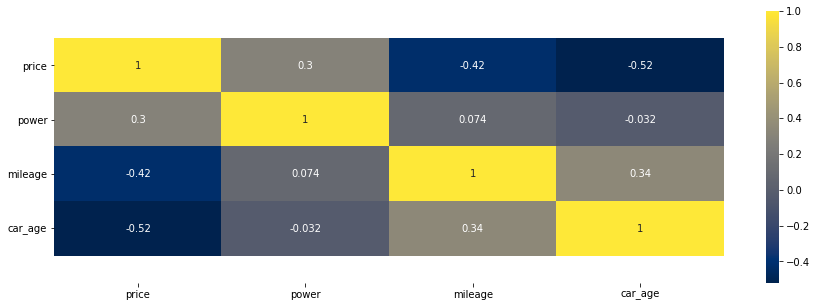

In [70]:
def corr(data):
    
    plt.figure(figsize=(15,5))
    ax = sns.heatmap(df.corr(), annot=True, cmap='cividis')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    plt.yticks(rotation=0);
corr(df)

The strongest correlation is between car_age and price in second place is mileage and price and in the third place is power and price but all the features have influence on the price of the vehicle.

Let's check for the missing values.

In [71]:
df.stb.missing(style=True) 

,missing,total,percent
notrepaired,"25,998","207,787",12.51%
fueltype,"8,924","207,787",4.29%
model,"7,261","207,787",3.49%
vehicletype,"6,064","207,787",2.92%
gearbox,"2,551","207,787",1.23%
price,0,"207,787",0.00%
power,0,"207,787",0.00%
mileage,0,"207,787",0.00%
brand,0,"207,787",0.00%
car_age,0,"207,787",0.00%


The features: fueltype, model, vehicletype and gearbox are all below 5% of missing values so we can drop those missing values,
however notrepaired feature has 12.5% of missing that cannot be neglected therefore KNN is needed here.

In [72]:
df['gearbox']=df['gearbox'].fillna(0)

In [73]:
df.gearbox.unique()

array(['manual', 'auto', 0], dtype=object)

In [74]:
df=df.drop(df[df['gearbox']== 0].index)

In [75]:
df.stb.missing(style=True) 

,missing,total,percent
notrepaired,"25,075","205,236",12.22%
fueltype,"8,514","205,236",4.15%
model,"6,983","205,236",3.40%
vehicletype,"5,693","205,236",2.77%
price,0,"205,236",0.00%
gearbox,0,"205,236",0.00%
power,0,"205,236",0.00%
mileage,0,"205,236",0.00%
brand,0,"205,236",0.00%
car_age,0,"205,236",0.00%


In [76]:
df['vehicletype']=df['vehicletype'].fillna(0)

In [77]:
df.vehicletype.unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 0,
       'other'], dtype=object)

In [78]:
df=df.drop(df[df['vehicletype']==0].index)

In [79]:
df.stb.missing(style=True) 

,missing,total,percent
notrepaired,"22,795","199,543",11.42%
model,"6,205","199,543",3.11%
fueltype,"5,978","199,543",3.00%
price,0,"199,543",0.00%
vehicletype,0,"199,543",0.00%
gearbox,0,"199,543",0.00%
power,0,"199,543",0.00%
mileage,0,"199,543",0.00%
brand,0,"199,543",0.00%
car_age,0,"199,543",0.00%


In [80]:
df['fueltype']=df['fueltype'].fillna(0)
df.fueltype.unique()

array(['gasoline', 'petrol', 0, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [81]:
df=df.drop(df[df['fueltype']==0].index)
df.stb.missing(style=True) 

,missing,total,percent
notrepaired,"21,047","193,565",10.87%
model,"5,254","193,565",2.71%
price,0,"193,565",0.00%
vehicletype,0,"193,565",0.00%
gearbox,0,"193,565",0.00%
power,0,"193,565",0.00%
mileage,0,"193,565",0.00%
fueltype,0,"193,565",0.00%
brand,0,"193,565",0.00%
car_age,0,"193,565",0.00%


In [82]:
df['model']=df['model'].fillna(0)
df.model.unique()

array([0, 'grand', 'golf', '3er', '2_reihe', 'c_max', '3_reihe', 'passat',
       'navara', 'twingo', 'a_klasse', 'scirocco', '5er', 'other',
       'civic', 'e_klasse', 'one', 'clio', '1er', 'b_klasse', 'a8',
       'jetta', 'c_klasse', 'micra', 'vito', 'sprinter', 'escort',
       'forester', 'xc_reihe', 'fiesta', 'scenic', 'a1', 'focus', 'a4',
       'tt', 'astra', 'a6', 'jazz', 'transporter', 'polo', 'slk', '7er',
       'combo', 'fabia', '80', '147', 'meriva', 'z_reihe', 'sorento',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'megane', 'a3',
       'r19', 'mondeo', 'colt', 'vectra', 'lupo', 'berlingo', 'tiguan',
       '6_reihe', 'c4', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe',
       'ibiza', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', 'corsa',
       '6er', 'beetle', 'fortwo', 'rio', 'touareg', 'caddy', 'omega',
       's_max', 'modus', 'a2', 'galaxy', 'c3', 'viano', 's_klasse',
       '1_reihe', 'panda', 'sharan', 'avensis', 'sl', 'santa', 'leon',
       'coope

In [83]:
df=df.drop(df[df['model']==0].index)
df.stb.missing(style=True) 

,missing,total,percent
notrepaired,"19,690","188,311",10.46%
price,0,"188,311",0.00%
vehicletype,0,"188,311",0.00%
gearbox,0,"188,311",0.00%
power,0,"188,311",0.00%
model,0,"188,311",0.00%
mileage,0,"188,311",0.00%
fueltype,0,"188,311",0.00%
brand,0,"188,311",0.00%
car_age,0,"188,311",0.00%


Now it is time to use KNN to fillin missing values in notrepaired feature.

In [84]:
df[['model','brand']].head(20)

,model,brand
2,grand,jeep
3,golf,volkswagen
5,3er,bmw
6,2_reihe,peugeot
8,c_max,ford
10,3_reihe,mazda
11,passat,volkswagen
12,passat,volkswagen
14,navara,nissan
17,twingo,renault


In [85]:
df.groupby(['brand','model']).size().sort_values(ascending=True).head(20)

brand       model             
fiat        seicento               1
land_rover  range_rover_evoque     1
rover       freelander             1
daewoo      matiz                  1
rover       defender               1
            discovery              2
            rangerover             2
lada        samara                 2
toyota      aygo                   3
smart       other                  3
land_rover  serie_2                3
chevrolet   matiz                  3
lada        kalina                 4
land_rover  other                  4
seat        other                  5
daihatsu    cuore                  5
bmw         i3                     5
daihatsu    move                   6
            charade               11
audi        q3                    11
dtype: int64

When we going to split the data to train and test with ration of 1:3 at lest for every brand 5 or more models needed otherwise the prediction will be wrong or will not work at all.

In [86]:
model_size=df.model.value_counts().to_frame()
model_size.head(15)

,model
golf,16052
other,15382
3er,13157
a4,6783
astra,6526
passat,6369
c_klasse,5773
5er,5604
e_klasse,4803
a3,4080


In [87]:
model_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, golf to range_rover_evoque
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   model   246 non-null    int64
dtypes: int64(1)
memory usage: 3.8+ KB


Now we will create dataframe with only those models that number of models less than 5.

In [88]:
model_size=model_size.drop(model_size[model_size['model']<5].index)
model_size.reset_index()
model_size.head()

,model
golf,16052
other,15382
3er,13157
a4,6783
astra,6526


In [89]:
model_size.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, golf to i3
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   model   238 non-null    int64
dtypes: int64(1)
memory usage: 3.7+ KB


In [90]:
df = df[df.model.isin(model_size.index) == True]

In [91]:
df.head()

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired,car_age
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,21
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,12
8,14500,bus,manual,125,c_max,30000,petrol,ford,NaN,2


In [92]:
df.model.value_counts()

golf       16052
other      15382
3er        13157
a4          6783
astra       6526
           ...  
gl            11
charade       11
move           6
cuore          5
i3             5
Name: model, Length: 238, dtype: int64

Let's split the data to train and test data.

In [93]:
df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 12345)

In [94]:
# Let's create target and features for train and test data. (not scaled yet)

target_train=df_train['price'].reset_index(drop=True)
target_test=df_test['price'].reset_index(drop=True)

features_train=df_train.drop(['price'],axis=1).reset_index(drop=True)
features_test=df_test.drop(['price'],axis=1).reset_index(drop=True)

Let's scaled the numeric features.

In [95]:
feature_names = [ 'power', 'mileage', 'car_age']

transformer_mas = MinMaxScaler().fit(df_train[feature_names].to_numpy())

df_nmrc_scaled_train = df_train.copy()
df_nmrc_scaled_train.loc[:, feature_names] = transformer_mas.transform(df_train[feature_names].to_numpy())

In [96]:
df_nmrc_scaled_train=df_nmrc_scaled_train.reset_index(drop=True)
df_nmrc_scaled_train.head()

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired,car_age
0,600,small,manual,0.011231,other,1.0,petrol,ford,NaN,0.197674
1,300,sedan,manual,0.009719,6_reihe,1.0,petrol,mazda,yes,0.174419
2,5790,wagon,auto,0.021598,passat,1.0,gasoline,volkswagen,no,0.116279
3,1990,wagon,manual,0.012743,c_klasse,1.0,petrol,mercedes_benz,no,0.174419
4,2800,coupe,manual,0.026350,rx_reihe,1.0,petrol,mazda,no,0.139535


In [97]:
transformer_mas = MinMaxScaler().fit(df_test[feature_names].to_numpy())

df_nmrc_scaled_test = df_test.copy()
df_nmrc_scaled_test.loc[:, feature_names] = transformer_mas.transform(df_test[feature_names].to_numpy())

In [98]:
df_nmrc_scaled_test=df_nmrc_scaled_test.reset_index(drop=True)
df_nmrc_scaled_test.head()

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired,car_age
0,4100,sedan,auto,0.023110,5er,1.000000,gasoline,bmw,no,0.135802
1,1200,wagon,manual,0.012959,megane,0.827586,gasoline,renault,yes,0.123457
2,4200,wagon,auto,0.017279,vectra,1.000000,gasoline,opel,no,0.123457
3,2850,suv,manual,0.014255,other,1.000000,petrol,opel,no,0.222222
4,7900,sedan,manual,0.012743,3er,1.000000,petrol,bmw,no,0.123457


All numeric features are scaled.

In [99]:
#Let's drop the categorial data so we could combine it with encoded categorial data.
df_nmrc_scaled_train.drop(['vehicletype','gearbox','model','fueltype','brand','notrepaired'],axis=1,inplace=True)
df_nmrc_scaled_test.drop(['vehicletype','gearbox','model','fueltype','brand','notrepaired'],axis=1,inplace=True)

In [100]:
df_nmrc_scaled_train.head(3)

,price,power,mileage,car_age
0,600,0.011231,1.0,0.197674
1,300,0.009719,1.0,0.174419
2,5790,0.021598,1.0,0.116279


In [101]:
df_nmrc_scaled_test.head(3)

,price,power,mileage,car_age
0,4100,0.023110,1.000000,0.135802
1,1200,0.012959,0.827586,0.123457
2,4200,0.017279,1.000000,0.123457


Now we need to encode categorial features for regression models.

In [102]:
encoder = OrdinalEncoder()
# function for encoding.

def encode(data_train, data_test):
 
 # Remaing only nonnull values
    nonulls_train = np.array(data_train.dropna())
    nonulls_test = np.array(data_test.dropna())
 
 # Reshaping the data for encoding
    impute_reshape_train = nonulls_train.reshape(-1,1)
    impute_reshape_test = nonulls_test.reshape(-1,1)
 
 # Encoding the data
    impute_ordinal_train = encoder.fit_transform(impute_reshape_train)
    impute_ordinal_test = encoder.transform(impute_reshape_test)
 
 #Assigning back encoded values to non-null values
    data_train.loc[data_train.notnull()] =np.squeeze(impute_ordinal_train)
    data_test.loc[data_test.notnull()] =np.squeeze(impute_ordinal_test)
    return data_train, data_test

cat_columns=['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
# Loop for iterating over the categorical columns for encoding
for i in cat_columns:
    encode(df_train[i], df_test[i])

df_train_encoded = df_train[cat_columns].reset_index(drop = True)
df_test_encoded = df_test[cat_columns].reset_index(drop = True)
df_train_encoded.head(3)



,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,5.0,1.0,161.0,6.0,10.0,NaN
1,4.0,1.0,16.0,6.0,19.0,1.0
2,7.0,0.0,165.0,2.0,36.0,0.0


Now we need to combine the scaled and encoded data.

In [103]:
df_train_com = pd.concat([df_nmrc_scaled_train, df_train_encoded], axis = 1).reset_index(drop = True)
df_train_com.head()

,price,power,mileage,car_age,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,600,0.011231,1.0,0.197674,5.0,1.0,161.0,6.0,10.0,NaN
1,300,0.009719,1.0,0.174419,4.0,1.0,16.0,6.0,19.0,1.0
2,5790,0.021598,1.0,0.116279,7.0,0.0,165.0,2.0,36.0,0.0
3,1990,0.012743,1.0,0.174419,7.0,1.0,57.0,6.0,20.0,0.0
4,2800,0.026350,1.0,0.139535,2.0,1.0,183.0,6.0,19.0,0.0


Now we need to fillin missing data to notrepaired feature with KNN.

In [104]:
imputer=KNNImputer()
df_train_imp=pd.DataFrame(imputer.fit_transform(df_train_com),columns=df_train_com.columns)

In [105]:
df_train_imp.stb.missing(style = True)

,missing,total,percent
price,0,"141,218",0.00%
power,0,"141,218",0.00%
mileage,0,"141,218",0.00%
car_age,0,"141,218",0.00%
vehicletype,0,"141,218",0.00%
gearbox,0,"141,218",0.00%
model,0,"141,218",0.00%
fueltype,0,"141,218",0.00%
brand,0,"141,218",0.00%
notrepaired,0,"141,218",0.00%


Great! No missing values :)

In [106]:
df_train_imp.head()

,price,power,mileage,car_age,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,600.0,0.011231,1.0,0.197674,5.0,1.0,161.0,6.0,10.0,0.0
1,300.0,0.009719,1.0,0.174419,4.0,1.0,16.0,6.0,19.0,1.0
2,5790.0,0.021598,1.0,0.116279,7.0,0.0,165.0,2.0,36.0,0.0
3,1990.0,0.012743,1.0,0.174419,7.0,1.0,57.0,6.0,20.0,0.0
4,2800.0,0.026350,1.0,0.139535,2.0,1.0,183.0,6.0,19.0,0.0


Now let's combine the test data set and fillin missing values with KNN.

In [107]:
df_test_com = pd.concat([df_nmrc_scaled_test, df_test_encoded], axis = 1).reset_index(drop = True)
df_test_com.head()

,price,power,mileage,car_age,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,4100,0.023110,1.000000,0.135802,4.0,0.0,15.0,2.0,2.0,0.0
1,1200,0.012959,0.827586,0.123457,7.0,1.0,144.0,2.0,27.0,1.0
2,4200,0.017279,1.000000,0.123457,7.0,0.0,222.0,2.0,24.0,0.0
3,2850,0.014255,1.000000,0.222222,6.0,1.0,161.0,6.0,24.0,0.0
4,7900,0.012743,1.000000,0.123457,4.0,1.0,11.0,6.0,2.0,0.0


In [108]:
imputer=KNNImputer()
df_test_imp=pd.DataFrame(imputer.fit_transform(df_test_com),columns=df_test_com.columns)

In [109]:
df_test_imp.stb.missing(style = True)

,missing,total,percent
price,0,"47,073",0.00%
power,0,"47,073",0.00%
mileage,0,"47,073",0.00%
car_age,0,"47,073",0.00%
vehicletype,0,"47,073",0.00%
gearbox,0,"47,073",0.00%
model,0,"47,073",0.00%
fueltype,0,"47,073",0.00%
brand,0,"47,073",0.00%
notrepaired,0,"47,073",0.00%


In [110]:
df_test_imp.head()

,price,power,mileage,car_age,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,4100.0,0.023110,1.000000,0.135802,4.0,0.0,15.0,2.0,2.0,0.0
1,1200.0,0.012959,0.827586,0.123457,7.0,1.0,144.0,2.0,27.0,1.0
2,4200.0,0.017279,1.000000,0.123457,7.0,0.0,222.0,2.0,24.0,0.0
3,2850.0,0.014255,1.000000,0.222222,6.0,1.0,161.0,6.0,24.0,0.0
4,7900.0,0.012743,1.000000,0.123457,4.0,1.0,11.0,6.0,2.0,0.0


Now all clear :)

## Model training

Let's create a list of categorical features for gradient boosting models.

In [111]:
cat_list=df_test_encoded.columns.to_list()

One of the gradient boosting model is datatype sensitive the other is not so we will convert calegorial encoded features to integers.

In [112]:
for i in range(len(cat_list)):
    df_train_imp[cat_list[i]] = df_train_imp[cat_list[i]].astype('int')
    df_test_imp[cat_list[i]] = df_test_imp[cat_list[i]].astype('int')


Let's create features and targets for train and test dataset.

In [113]:
#Train
features_train = df_train_imp.drop('price', axis = 1)
target_train = df_train_imp.price

#Test
features_test = df_test_imp.drop('price', axis = 1)
target_test = df_test_imp.price


Let's create RMSE function for training set.

In [114]:
def rmse(true_answers, predictions):
    return math.sqrt(mean_squared_error(true_answers, predictions))

Let's create scorer for GridSearchCV.

In [115]:
rmse = make_scorer(rmse, greater_is_better = False)

Let's create a function to train non gradient models with GridSearchCV. (Cross Validation with tuning the models)

In [116]:
def train_fit_nongrad(model, param, name ):
    model = GridSearchCV(model, param_grid = param, scoring = rmse, verbose = 0, refit = True)
    model.fit(features_train, target_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns = ['model', 'best_score','best_params'])


The same (almost) for the gradient models.

In [117]:
def train_fit_grad(model, param, name, grad_method, categories_list):
    model = GridSearchCV(model, param_grid = param, scoring = rmse, verbose = 0, refit = True)
    if grad_method == 'lgbm':
        model.fit(features_train, target_train, categorical_feature =categories_list)
    else:
        model.fit(features_train, target_train, silent = True, cat_features = categories_list)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns = ['model', 'best_score','best_params'])

Let's create Random Forest Regressor.

In [118]:
%%time

RandomForest =train_fit_nongrad(RandomForestRegressor(random_state=12345), {'n_estimators' : range(10, 85, 25),
 'max_depth' : range(5, 45, 10),'min_impurity_decrease' : np.arange(.05, .25,.1)}, 'Random_Forest')


CPU times: user 15min 59s, sys: 17.1 s, total: 16min 16s
Wall time: 16min 17s


Let's create Decision Tree Regressor.

In [119]:
%%time

DecisionTree =train_fit_nongrad(DecisionTreeRegressor(random_state=12345), {'max_depth': range(5, 10, 5), 
          'min_impurity_decrease' : np.arange(.01, .20,.02), 'min_samples_split' : range(2, 10, 2)}, 'Decision_Tree')


CPU times: user 24.1 s, sys: 63.1 ms, total: 24.1 s
Wall time: 24.5 s


Let's create CatBoost Regressor.

In [120]:
%%time

CatBoost_regressor =train_fit_grad(CatBoostRegressor(random_state = 12345), {'verbose':[0],
                    'n_estimators' : range(0, 75, 25),'max_depth' : range(5, 45, 10)}, 'CatBoost', 'catboost', cat_list)

CPU times: user 3min 32s, sys: 48.5 s, total: 4min 21s
Wall time: 4min 33s


Let's create Light GBM Regressor.

In [ ]:
%%time

LightGBM_regressor =train_fit_grad(lgb.LGBMRegressor(random_state = 12345), {'learning_rate': np.arange(0.01, 1, 0.1),
 'n_estimators' : range(0, 75, 25),'max_depth' : range(5, 45, 10)}, 'LightGBM', 'lgbm', cat_list)


Let's create Lasso Regressor as sanity check.

In [ ]:
%%time

Lasso_regressor = train_fit_nongrad(Lasso(random_state=12345), {'alpha' : np.arange(.01, 1, .05)}, 'Lasso_Regressor')


Let's show the results.

In [ ]:
scores = pd.concat([DecisionTree, RandomForest, LightGBM_regressor, CatBoost_regressor, Lasso_regressor]).set_index('model')
scores['best_score'] = scores['best_score'].round(1)
display(scores.drop('best_params', axis=1).sort_values(by='best_score'))

Time also needs to be added.

Let's create list of time results.

In [ ]:
wall_time=['21.4S','11Min 57S','8Min 42S','3Min 48S','29.5S']

In [ ]:
scores['trained_time'] = wall_time
display(scores.drop('best_params', axis=1).sort_values(by='best_score'))

Let's test the models.

Let's create RMSE function.

In [ ]:
def rmse_test(true_answers, predictions):
    return math.sqrt(mean_squared_error(true_answers, predictions))

Let's create a function for predictions and RMSE values.

In [ ]:
# Setting a dictionary for models' RMSE scores
rmse_dic = {}
def model_pred_rmse (model ,x_test, y_test, model_name):
    prediction = model.predict(x_test)
    model_rmse = rmse_test(y_test, prediction)
    rmse_dic[model_name] = model_rmse

Let's create function to train a models with best parametors.

In [ ]:
def train_model_best_params(model, x_train, y_train, model_parameters):
    model = model(**scores['best_params'][model_parameters])
    model.fit(x_train, y_train)
    return model

Training and testing Random Forest Regressor.

In [ ]:
%%time 

Random_Forest = train_model_best_params(RandomForestRegressor, features_train, target_train, 'Random_Forest')

In [ ]:
%%time

model_pred_rmse (Random_Forest ,features_test, target_test, 'Random_Forest')

Training and testing Decision Tree Regressor.

In [ ]:
%%time 

Decision_Tree = train_model_best_params(DecisionTreeRegressor, features_train, target_train, 'Decision_Tree')

In [ ]:
%%time 

model_pred_rmse (Decision_Tree ,features_test, target_test, 'Decision_Tree')

Training and testing CatBoost Regressor.

In [ ]:
%%time

CatBoost = train_model_best_params(CatBoostRegressor, features_train, target_train, 'CatBoost')

In [ ]:
%%time

model_pred_rmse (CatBoost ,features_test, target_test, 'CatBoost')

Training and testing  Light GBM Regressor.

In [ ]:
%%time

LightGBM = train_model_best_params(lgb.LGBMRegressor, features_train, target_train, 'LightGBM')

In [ ]:
%%time

model_pred_rmse (LightGBM ,features_test, target_test, 'LightGBM')

Training and testing Lasso Regressor.

In [ ]:
%%time 

Lasso_Regressor = train_model_best_params(Lasso, features_train, target_train, 'Lasso_Regressor')

In [ ]:
%%time

model_pred_rmse (Lasso_Regressor ,features_test, target_test, 'Lasso_Regressor')


In [ ]:
#Time lists.
train_time=['12S','137mS','23.3S','101mS','1.63S']
predict_time=['463mS','5.56mS','22mS','4.44mS','110mS']


In [ ]:
models_best_parms_rmse = pd.DataFrame(rmse_dic.values(), index =rmse_dic.keys())
models_best_parms_rmse.columns = ['rmse']
models_best_parms_rmse['train_time'] = train_time
models_best_parms_rmse['predict_time'] = predict_time
models_best_parms_rmse = models_best_parms_rmse.sort_values(by ='rmse')
models_best_parms_rmse


# Model analysis.

From the results above the conclusion is that Gradient Boosting methods performed better than other regression models. The RMSE score is better and the time is small value.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed